# Task 1. Tree Visualization

## Layered-Tree-Draw Algorithm

We will use the following libs:
- **networkx** - for graph reading and processing
- **matplotlib** - for graph plotting

In [2]:
!pip install networkx matplotlib

You should consider upgrading via the 'c:\users\nikita\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [3]:
import networkx as nx
import matplotlib.pyplot as plt

For convenience, let's create a class with all necessary methods:

In [10]:
class Tree:
    def __init__(self, path: str):
        """
        Reads tree from file with path and create Tree object
        :param path: path of file with tree
        """
        self.G = nx.read_graphml(path)
        self.root = self.find_root()

    def find_root(self):
        """
        Finds the root of tree
        :return: root node
        """
        # If vertex has no incoming edges - it is a root
        for node, in_degree in self.G.in_degree():
            if in_degree == 0:
                return node

    def __compute_coord(self, root, x_curr, y_curr):
        """
        Calculates the coordinates of the vertices of the subtree rooted at "root" so that:
         neighbors [0, num_neighbors // 2) were to the left of the root of the subtree,
         neighbors [num_neighbors // 2, num_neighbors) - to the right of the root of the subtree
        :param root: a root of subtree
        :param x_curr: the x-coordinate at which to start calculating the coordinates
        :param y_curr: the y-coordinate at which to start calculating the coordinates
        """
        # Find the child vertices of the root of the subtree
        neighbors = [node for node in self.G.neighbors(root)]
        num_neighbors = len(neighbors)

        # Calculate the coordinates for the left child subtrees
        for neighbor in neighbors[:num_neighbors // 2]:
            x_curr = self.__compute_coord(neighbor, x_curr, y_curr+1)

        # Calculate the coordinates for the subtree root
        self.G.nodes[root]['x'] = x_curr
        self.G.nodes[root]['y'] = y_curr
        if num_neighbors != 1:
            x_curr += 1

        # Calculate the coordinates for the right child subtrees
        for neighbor in neighbors[num_neighbors // 2:]:
            x_curr = self.__compute_coord(neighbor, x_curr, y_curr+1)

        return x_curr

    def __compute_sillouete(self, root):
        """
        Computes the silhouette of the subtree rooted at "root"
        :param root: a root of subtree
        """
        # Find the child vertices of the root of the subtree
        neighbors = [node for node in self.G.neighbors(root)]
        num_neighbors = len(neighbors)

        # If there are no child vertices, then the silhouette is set by the coordinates of the root itself
        if num_neighbors == 0:
            self.G.nodes[root]['sillouete'] = [
                [self.G.nodes[root]['x'], self.G.nodes[root]['x']]
            ]
        # If there is only one child vertex, then the silhouette is extended by the coordinates of the root itself
        elif num_neighbors == 1:
            self.__compute_sillouete(neighbors[0])
            self.G.nodes[root]['sillouete'] = [[self.G.nodes[root]['x'], self.G.nodes[root]['x']]] + self.G.nodes[neighbors[0]]['sillouete']
        else:
        # If there are several child vertices, then we consider the silhouette of all subtrees and supplement it with the coordinates of the root itself
            for n in neighbors:
                self.__compute_sillouete(n)
            self.G.nodes[root]['sillouete'] = [[self.G.nodes[root]['x'], self.G.nodes[root]['x']]]
            depths = [len(self.G.nodes[n]['sillouete']) for n in neighbors]
            for y in range(max(depths)):
                lefts = []
                rights = []
                for n in neighbors:
                    n_sil = self.G.nodes[n]['sillouete']
                    try:
                        lefts.append(n_sil[y][0])
                        rights.append(n_sil[y][1])
                    except IndexError:
                        pass
                left = min(lefts)
                right = max(rights)
                self.G.nodes[root]['sillouete'] = self.G.nodes[root]['sillouete'] + [[left, right]]

    def __fix_coords(self, root):
        """
        Shrinks a subtree rooted at "root"
        :param root: a root of subtree
        """
        # Find the child vertices of the root of the subtree
        neighbors = [node for node in self.G.neighbors(root)]
        num_neighbors = len(neighbors)

        # Shift the coordinates of all child subtrees
        for n in neighbors:
            self.__fix_coords(n)

        # If there are no child vertices, then do nothing
        if num_neighbors == 0:
            return None
        # If there are at least two child vertices, then we perform a shift for each subtree whose root is the child vertex
        elif num_neighbors >= 2:
            for i in range(1, num_neighbors):  # Do not move the first peak, everything is fine with it
                n2 = neighbors[i]
                # Find the maximum possible distance by which we can shift the subtree rooted at n2 so that there is no overlapping of vertices
                dists = []
                for j in range(0, i):
                    n1 = neighbors[j]
                    dists.append(self.__calc_dist(n1, n2))
                dist = min(dists)
                self.__shift_subtree(n2, - (dist - 1))  # Execute a shift
                self.__compute_sillouete(n2)  # Recalculate the silhouette of the n2 subtree
        self.G.nodes[root]['x'] = sum([self.G.nodes[n]['x'] for n in neighbors]) // num_neighbors  # Update the root coordinate
        self.__compute_sillouete(root)  # Recalculate the silhouette of the main subtree

    def __calc_dist(self, n1: str, n2: str):
        """
        Calculates the distance between two subtrees with a common ancestor with roots at the vertices
        :param n1: Left subtree root
        :param n2: Right subtree root
        """
        s1 = self.G.nodes[n1]['sillouete']
        s2 = self.G.nodes[n2]['sillouete']
        dists = []
        for y in range(max(len(s1), len(s2))):
            try:
                dists.append(s2[y][0] - s1[y][1])
            except IndexError:
                pass
        return min(dists)

    def __shift_subtree(self, root, shift):
        """
        Shifts the subtree with the root at "root" by "shift" to the right
        :param root: a root of subtree
        :param shift: value of the shift
        """
        self.G.nodes[root]['x'] += shift
        for n in self.G.neighbors(root):
            self.__shift_subtree(n, shift)


    def plot_graph(self, condensed=True, save=True, save_path='result.svg'):
        """
        Plots the graph
        :param condensed: Whether to compress the coordinates of the tree vertices
        :type condensed: bool
        :param save: Should the tree visualization be saved to a file
        :type save: bool
        :param save_path: Path to save the tree visualization
        :type save_path: str
        """
        self.__compute_coord(self.root, x_curr=0, y_curr=0)
        self.__compute_sillouete(self.root)
        if condensed:
            self.__fix_coords(self.root)

        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        for start in self.G.nodes:
            for end in self.G.neighbors(start):
                x1 = self.G.nodes[start]['x']
                y1 = self.G.nodes[start]['y']
                x2 = self.G.nodes[end]['x']
                y2 = self.G.nodes[end]['y']

                ax.plot([x1,x2], [y1,y2],linestyle='-', marker='o', ms=10, markerfacecolor='blue', color='black')

        plt.gca().invert_yaxis()
        plt.axis('off')
        plt.show()

        if save:
            fig.savefig(save_path)

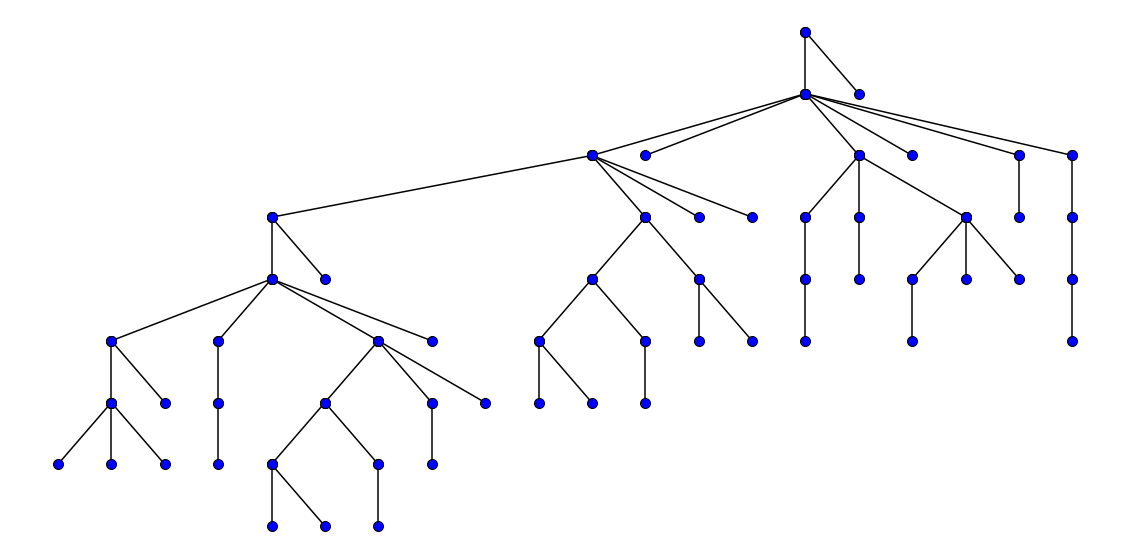

In [11]:
tree = Tree('inputs/task1.xml')
tree.plot_graph(
    condensed=True,
    save=True,
    save_path='outputs/task1.svg'
)